In [24]:
import numpy as np
import pandas as pd
import torch
from datetime import datetime
import h5py

from aidapy import load_data
from aidapy.ml.lstm.preprocess import (controlled_train_test_split, split_data,
extract_data, preprocess_data, format_to_lstm_input)
from aidapy.ml.lstm.utils import numpy_to_dataloader, run_model, extract_continuous_intervals, reformat_dtw_res
from aidapy.ml.lstm.model import LSTMnn
from aidapy.ml.lstm.visualize import plot_set_of_storms
from aidapy.ml.lstm.dtw import dtw_measure

%matplotlib notebook

In [13]:
start_time = datetime(2001, 1, 14, 0, 0, 0)
end_time = datetime(2016, 1, 1, 0, 0, 0)
settings = {'prod': ['all']}

output = 'DST Index'
time_forward = 6
time_back = 6

omni_data = load_data(mission='omni', start_time=start_time, end_time=end_time, **settings)

features = ['DST Index', 'Magnitude of Avg Field Vector', 'Bz GSM', 'Proton Density', 'Plasma Flow Speed']

df = pd.DataFrame(omni_data['all1'].values, index = omni_data['all1'].coords['time1'].values, columns = omni_data['all1'].coords['products'].values)
df['Delta_Dst'] = df['DST Index'].diff()

In [14]:
train, test = controlled_train_test_split(df)
train, valid = split_data(train, 0.2, 'M')
train_in, train_out = extract_data(train, features, output)
valid_in, valid_out = extract_data(valid, features, output)
test_in, test_out = extract_data(test, features, output)

tr_in, sclr = preprocess_data(train_in)
val_in, _ = preprocess_data(valid_in, sclr)
t_in, _ = preprocess_data(test_in, sclr)

train_in, train_out, _ = format_to_lstm_input(tr_in, train_out, time_back, time_forward)
valid_in, valid_out, _ = format_to_lstm_input(val_in, valid_out, time_back, time_forward)
test_in, test_out, lookup = format_to_lstm_input(t_in, test_out, time_back, time_forward)

In [15]:
def get_storm_dates(stormname='storms_1981_2016.csv'):
    return pd.read_csv(stormname, index_col=0, dtype={'date1': str, 'date2': str},
                       parse_dates=['date1', 'date2'])

def get_storms(data, storm_dates):
    '''Check which storms lie in the given dataset
    Input:
        data: dataset with dates
        storm_dates: list of known storm occurences
    Output:
        measured features during the storm
        storm-dates that lie in data
    '''
    rs = []
    valid_storms = []
    for (_, dates) in storm_dates.iterrows():
        ss = data.loc[dates[0]:dates[1]]
        if ss.shape[0] != 0:
            rs.append(ss)
            valid_storms.append((dates[0].strftime('%Y-%m-%d'), dates[1].strftime('%Y-%m-%d')))
    print('Number of storms in dataset: {}'.format(len(valid_storms)))
    return pd.concat(rs), np.array(valid_storms)

In [16]:
storm_dates = get_storm_dates()
test_storms, test_storm_dates = get_storms(test, storm_dates)
test_storm_dates = test_storm_dates.astype('datetime64')

Number of storms in dataset: 17


In [17]:
time_forward = train_out.shape[2]
time_back = train_in.shape[1]
num_epochs = 30
hidden_size = 50
momentum = 0.8
num_layers = 1
learning_rate = 0.0003
batch_size = 64
num_feat = train_in.shape[2]

In [18]:
train = numpy_to_dataloader(train_in, train_out, batch_size)
valid = numpy_to_dataloader(valid_in, valid_out, 1024)

In [19]:
model = LSTMnn(num_feat, num_layers, hidden_size, time_forward)
predict = run_model(model, test_in, file_path='model/model')

<IPython.core.display.Javascript object>


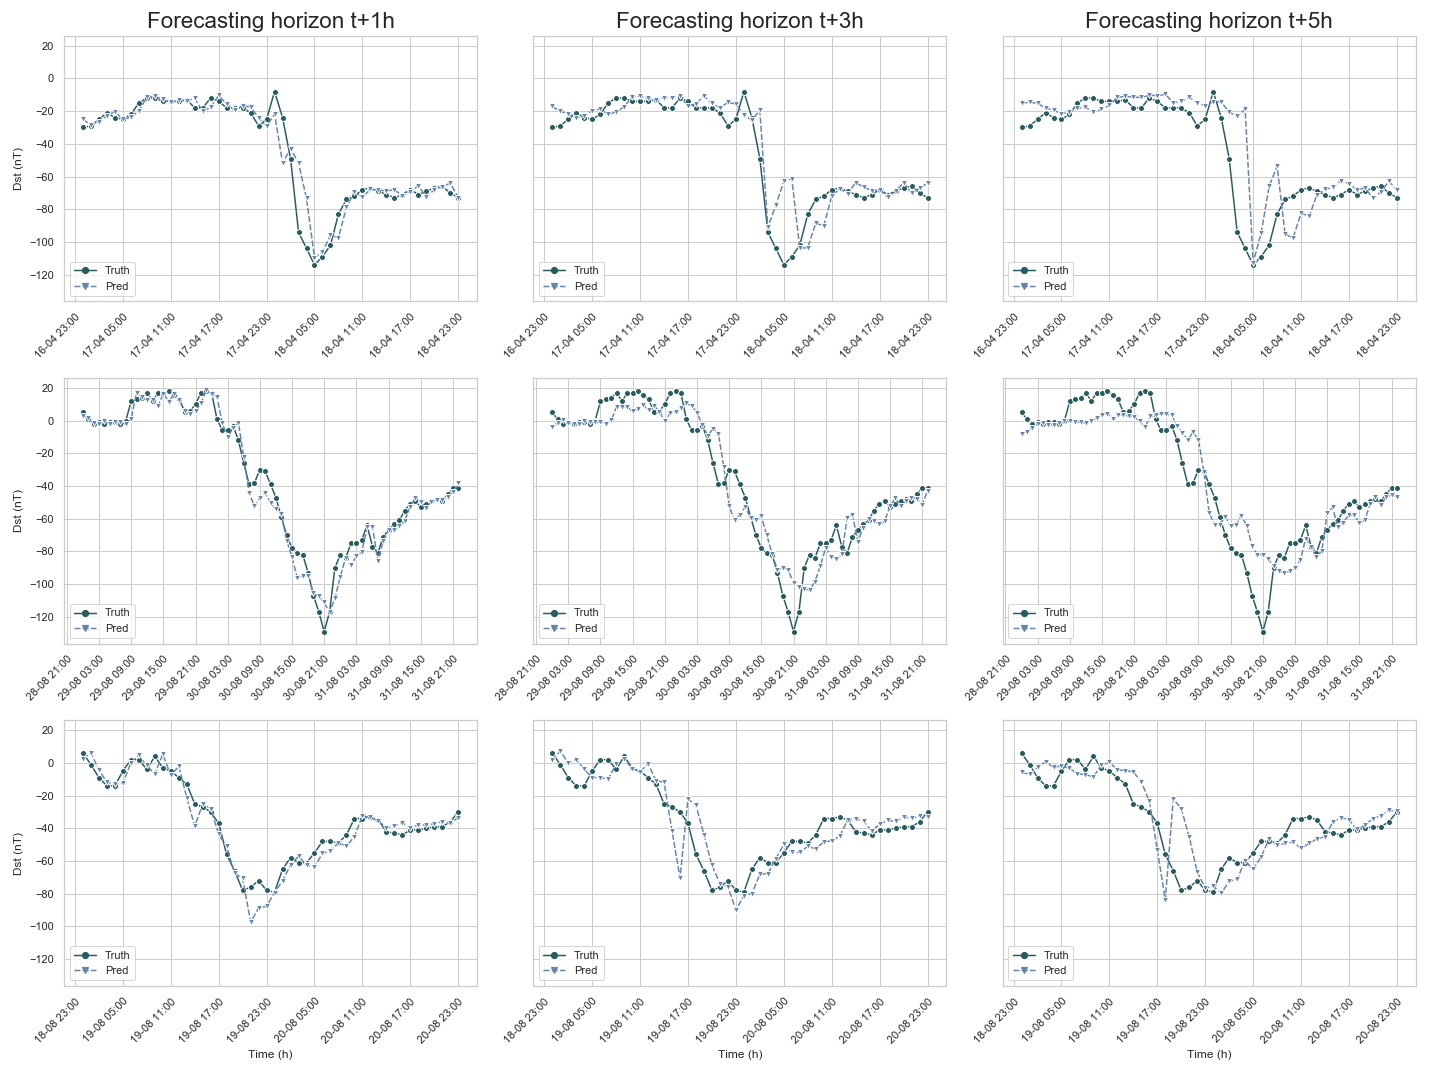

In [20]:
times = [0, 2, 4]
selected_storms = [test_storm_dates[0], test_storm_dates[7], test_storm_dates[13]]
plot_set_of_storms(test_out[:, 0], predict[:, 0], lookup, selected_storms, times, save=False)

In [21]:
intervals = extract_continuous_intervals(lookup)

In [22]:
bincounts = np.zeros((time_forward,7))
counter = 0
for start, stop in intervals:
    counter += 1
    for i in range(time_forward):
        _, path, _ = dtw_measure(predict[start:stop, 0, i], test_out[start:stop, 0, i], time_forward)
        bins, counts = np.unique(abs(path[0, :] - path[1, :]), return_counts=True)
        bincounts[i, bins] += counts
        
lat_res = pd.DataFrame(data=bincounts, index=np.arange(1, time_forward+1), columns=np.arange(7))
print(lat_res)

         0        1        2        3        4        5        6
1  10744.0  22484.0   1453.0    466.0    168.0     69.0     29.0
2   3686.0  12344.0  17144.0   2670.0   1087.0    543.0    271.0
3   2816.0   4190.0  10800.0  14671.0   3851.0   1867.0   1273.0
4   2773.0   2628.0   4470.0   9406.0  12592.0   4758.0   3484.0
5   2995.0   2270.0   2927.0   4611.0   8460.0  10972.0   7696.0
6   3436.0   2103.0   2593.0   3222.0   4637.0   7783.0  15365.0


In [25]:
reformat_dtw_res(lat_res)

,0h,1h,2h,3h,4h,5h,6h
Prediction,,,,,,,
t+1h,0.303,0.635,0.041,0.013,0.005,0.002,0.001
t+2h,0.098,0.327,0.454,0.071,0.029,0.014,0.007
t+3h,0.071,0.106,0.274,0.372,0.098,0.047,0.032
t+4h,0.069,0.066,0.111,0.234,0.314,0.119,0.087
t+5h,0.075,0.057,0.073,0.115,0.212,0.275,0.193
t+6h,0.088,0.054,0.066,0.082,0.118,0.199,0.393
